In [ ]:
!pip install datasets
!pip install pip install accelerate -U
exit()

In [1]:
import torch

from datasets import load_dataset, Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, AutoModelForSequenceClassification

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Training Tokenizer

In [3]:
raw_dataset = pd.read_csv('drive/MyDrive/combined.csv')

In [4]:
raw_dataset.drop_duplicates(inplace = True)

In [5]:
raw_dataset.head()

,title,content,label
0,ज़िम्मेदारी ड्राइवर लेगा: बेटे के काफिले की कार...,कैसरगंज (यूपी) से बीजेपी सांसद बृजभूषण शरण सिं...,national
1,"जम्मू-कश्मीर में गहरी खाई में गिरी बस, 10 यात्...",अखनूर (जम्मू-कश्मीर) में गुरुवार को यात्रियों ...,national
2,मुंबई के होटल कारोबारी मर्डर केस में डॉन छोटा ...,मुंबई में होटल व्यवसायी जय शेट्टी की हत्या के ...,national
3,प्रज्वल वापस नहीं लौटे तो उनके पासपोर्ट को रद्...,कर्नाटक के गृह मंत्री जी परमेश्वर ने कहा है कि...,national
4,मनी लॉन्डरिंग केस में झारखंड के पूर्व सीएम सोर...,रांची (झारखंड) स्थित पीएमएलए के स्पेशल कोर्ट न...,national


In [10]:
raw_dataset['label'].unique()

array(['politics', 'sports', 'technology'], dtype=object)

In [11]:
raw_dataset.reset_index(inplace = True, drop = True)

In [12]:
raw_dataset.head()

,title,content,label
0,"प्रिय अमिताभ, इस बारे में ट्वीट कर मदद करें: य...",केरल कांग्रेस ने यूपी में खचाखच भरी एक ट्रेन क...,politics
1,बंगाल में लोकसभा चुनाव लड़ रहे 507 उम्मीदवारों...,'पश्चिम बंगाल इलेक्शन वॉच' और एडीआर द्वारा की ...,politics
2,चंडीगढ़ में कांग्रेस प्रत्याशी मनीष तिवारी व बस...,चंडीगढ़ में गुरुवार को कांग्रेस प्रत्याशी मनीष ...,politics
3,महाकाल के दर्शन करने के बाद ज्योतिरादित्य सिंध...,भोपाल: केंद्रीय मंत्री ज्योतिरादित्य सिंधिया न...,politics
4,Jammu and Kashmir: श्रीनगर में ED की बड़ी कार्...,श्रीनगर: प्रवर्तन निदेशालय (ईडी) ने जम्मू-कश्म...,politics


In [13]:
raw_dataset.isna().sum()

title      0
content    0
label      0
dtype: int64

In [15]:
raw_dataset['train'] = raw_dataset.progress_apply(lambda x : x['title'] + ' | ' + x['content'], axis = 1)

  0%|          | 0/5932 [00:00<?, ?it/s]

In [51]:
raw_dataset['train']

0       ज़िम्मेदारी ड्राइवर लेगा: बेटे के काफिले की कार...
1       जम्मू-कश्मीर में गहरी खाई में गिरी बस, 10 यात्...
2       मुंबई के होटल कारोबारी मर्डर केस में डॉन छोटा ...
3       प्रज्वल वापस नहीं लौटे तो उनके पासपोर्ट को रद्...
4       मनी लॉन्डरिंग केस में झारखंड के पूर्व सीएम सोर...
                              ...                        
9886    अमेरिका ने अपने क्षेत्रफल में किया स्पेन के क्...
9887    1 जनवरी को आए शक्तिशाली भूकंप के बाद जापान में...
9888    बेंगलुरु जाते समय ट्रेन में ब्रिटेन की महिला क...
9889    मालदीव की संप्रभुता का समर्थन करता है चीन: भार...
9890    प्रधानमंत्री नरेंद्र मोदी ने रूसी राष्ट्रपति व...
Name: train, Length: 9887, dtype: object

In [16]:
training_corpus = [raw_dataset["train"][i: i + 1000] for i in range(0, len(raw_dataset["train"]), 1000)]

In [17]:
old_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [18]:
tokenizer = old_tokenizer.train_new_from_iterator(training_corpus, 30522)

In [19]:
tokens = tokenizer.tokenize('उम्मीद के मुताबिक 11.6-इंच डिस्प्ले साइज़ के हिसाब से विवोबुक एफ202ई काफी कॉम्पैक्ट है।')
tokens

['उममीद',
 'क',
 'मताबिक',
 '11',
 '.',
 '6',
 '-',
 'इच',
 'डिसपल',
 'साइज',
 'क',
 'हिसाब',
 'स',
 'वि',
 '##वो',
 '##बक',
 'एफ',
 '##20',
 '##2',
 '##ई',
 'काफी',
 'कॉमप',
 '##कट',
 'ह',
 '।']

In [20]:
from huggingface_hub import notebook_login
notebook_login()

In [21]:
tokenizer.push_to_hub("3-classes-tokenizer-hindi-politics-sports-technology")

CommitInfo(commit_url='https://huggingface.co/jaskaran277/3-classes-tokenizer-hindi-politics-sports-technology/commit/40af73ffc3ef69b8854616f578141469006a3c47', commit_message='Upload tokenizer', commit_description='', oid='40af73ffc3ef69b8854616f578141469006a3c47', pr_url=None, pr_revision=None, pr_num=None)

# DataLoading

In [22]:
df = pd.read_csv('drive/MyDrive/combined.csv')

In [23]:
df.drop_duplicates(inplace = True)

In [25]:
df.head()

,title,content,label
1960,"प्रिय अमिताभ, इस बारे में ट्वीट कर मदद करें: य...",केरल कांग्रेस ने यूपी में खचाखच भरी एक ट्रेन क...,politics
1961,बंगाल में लोकसभा चुनाव लड़ रहे 507 उम्मीदवारों...,'पश्चिम बंगाल इलेक्शन वॉच' और एडीआर द्वारा की ...,politics
1962,चंडीगढ़ में कांग्रेस प्रत्याशी मनीष तिवारी व बस...,चंडीगढ़ में गुरुवार को कांग्रेस प्रत्याशी मनीष ...,politics
1963,महाकाल के दर्शन करने के बाद ज्योतिरादित्य सिंध...,भोपाल: केंद्रीय मंत्री ज्योतिरादित्य सिंधिया न...,politics
1964,Jammu and Kashmir: श्रीनगर में ED की बड़ी कार्...,श्रीनगर: प्रवर्तन निदेशालय (ईडी) ने जम्मू-कश्म...,politics


In [26]:
df['train'] = df.progress_apply(lambda x : x['title'] + ' | ' + x['content'], axis = 1)

  0%|          | 0/5932 [00:00<?, ?it/s]

In [27]:
X = df['train']
Y=LabelEncoder().fit_transform(df['label'])

<Axes: xlabel='label', ylabel='count'>

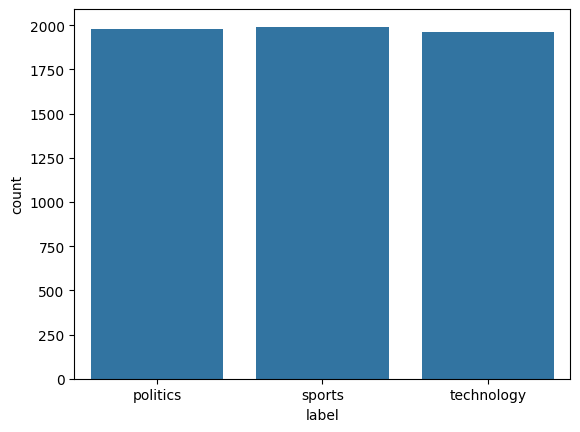

In [28]:
sns.countplot(data = df, x = 'label')

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 42, test_size = 0.1, stratify = df['label'])

# Training

In [30]:
tokenizer_checkpoint = 'jaskaran277/3-classes-tokenizer-hindi-politics-sports-technology'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/370k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/764k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [31]:
train_df = pd.DataFrame({
    "label" : Y_train,
    "text" : X_train
})
train_df.reset_index(drop=True, inplace=True)
train_df

,label,text
0,1,टी20 वर्ल्ड कप जीतने के लिए द्रविड़ को टीम में ...
1,2,चंद्रयान-3 के प्रज्ञान रोवर ने चंद्रमा के दक्ष...
2,2,ट्विटर पर 4 दिन बाद डोज मीम की जगह फिर दिखने ल...
3,0,'आप' विधायक अमानतुल्लाह खान को गिरफ्तार नहीं क...
4,1,दिल की बीमारी के चलते इंग्लैंड के घरेलू क्रिके...
...,...,...
5333,2,अंतरिक्षयात्री ने शेयर कीं हिंदू कुश पर्वत श्र...
5334,2,नासा का आईएसएस से थोड़ी देर के लिए टूटा संपर्क...
5335,2,रूस में नदी पर देखा गया दुर्लभ 'गोल्डन वॉटरस्प...
5336,1,केकेआर ने बनाया आईपीएल के इतिहास में ईडन गार्ड...


In [32]:
validation_df = pd.DataFrame({
    "label" : Y_test,
    "text" : X_test
})
validation_df.reset_index(drop=True, inplace=True)
validation_df

,label,text
0,1,"अक्षय, एआर रहमान व सोनू निगम ने आईपीएल 2024 की..."
1,1,कुलदीप के मायाजाल में फंसे लखनऊ के नवाब | लखनऊ...
2,1,टी20 विश्व कप जीतने पर पाकिस्तानी टीम के प्रत्...
3,2,नासा ने शेयर की पृथ्वी को ढकते 'सफेद और गुलाबी...
4,0,कब और किस राज्य की कौन-सी सीट पर होंगे पहले चर...
...,...,...
589,1,आरआर-आरसीबी मैच के टिकटों के लिए जयपुर में सुब...
590,1,आईपीएल के इतिहास में सबसे तेज़ 150 विकेट लेने व...
591,0,यूपी की इन 8 सीटों पर सपा ने बदले अपने प्रत्या...
592,0,हाजीपुर से लोकसभा चुनाव नहीं लड़ेंगे पशुपति पा...


In [33]:
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(validation_df)
my_dataset_dict = DatasetDict({"train":train_dataset,"validation":valid_dataset})

In [34]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)
tokenized_datasets = my_dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/5338 [00:00<?, ? examples/s]

Map:   0%|          | 0/594 [00:00<?, ? examples/s]

In [35]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [36]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [37]:
training_args = TrainingArguments("3-classes-hindi-news-classification",learning_rate=2e-5, num_train_epochs=10, evaluation_strategy="steps", do_train=True, do_eval=True)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [38]:
def compute_metrics(eval_preds):

  metric1 = load_metric('accuracy', trust_remote_code=True)


  logits, labels = eval_preds
  predictions = np.argmax(logits,axis = -1)
  accuracy = metric1.compute(predictions=predictions, references=labels)["accuracy"]

  return {"accuracy": accuracy}

In [39]:
checkpoint = "google-bert/bert-base-uncased"
num_labels = 3

In [40]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [42]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [43]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
500,0.835000,0.981007,0.680135
1000,0.386400,0.566228,0.887205
1500,0.240300,0.280592,0.949495
2000,0.148800,0.260975,0.959596
2500,0.092300,0.192956,0.968013
3000,0.083800,0.244447,0.962963
3500,0.075700,0.188713,0.971380
4000,0.051700,0.155078,0.974747
4500,0.040800,0.223716,0.966330
5000,0.030900,0.197975,0.973064


<ipython-input-38-963de8e1ebc3>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric1 = load_metric('accuracy', trust_remote_code=True)


TrainOutput(global_step=6680, training_loss=0.15354083765766577, metrics={'train_runtime': 1306.8926, 'train_samples_per_second': 40.845, 'train_steps_per_second': 5.111, 'total_flos': 2722367727090396.0, 'train_loss': 0.15354083765766577, 'epoch': 10.0})

In [44]:
trainer.evaluate()

{'eval_loss': 0.13508369028568268,
 'eval_accuracy': 0.9831649831649831,
 'eval_runtime': 4.39,
 'eval_samples_per_second': 135.307,
 'eval_steps_per_second': 17.084,
 'epoch': 10.0}

In [45]:
trainer.push_to_hub('3-classes-hindi-news-classification')

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

events.out.tfevents.1717147024.ca8ee75cfbd4.1996.0:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

events.out.tfevents.1717148343.ca8ee75cfbd4.1996.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jaskaran277/3-classes-hindi-news-classification/commit/183ad14176b35f908340e9e2cc7140dbad2b32d5', commit_message='3-classes-hindi-news-classification', commit_description='', oid='183ad14176b35f908340e9e2cc7140dbad2b32d5', pr_url=None, pr_revision=None, pr_num=None)